## Context

ML-driven sentiment analysis is an important tool to understand communities’ feelings around major issues such as COVID-19. Gathering comprehensive social data for sentiment analysis can be limited, however, if data collection relies only on keywords such as ‘coronavirus’ or ‘covid’.

### Objective

The objective of this task is to develop a machine learning model to assess if a Twitter post is about COVID-19 or not. This model will help gather tweet data about the epidemic without relying only on key words like ‘covid’ or ‘coronavirus’ being present, allowing researchers and engineers to gather a more comprehensive dataset for sentiment analysis.

This model could be put into practice as part of a larger effort to understand online sentiment around COVID-19, and inform future communications and public interventions by governments and non-government public health organisations.

### Set_Up and DataLoading

In [ ]:
!pip install transformers
!pip install datasets
!pip uninstall umap
!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import load_dataset

In [ ]:
## loading data from github
tweets = pd.read_csv('https://raw.githubusercontent.com/chimaobi-okite/NewsClassification/main/updated_train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/chimaobi-okite/NewsClassification/main/updated_test.csv')
ss = pd.read_csv('https://raw.githubusercontent.com/chimaobi-okite/NewsClassification/main/updated_ss.csv')

## Expository Data Analysis

In [ ]:
## read the train data
tweets.head()

,ID,text,target
0,train_0,The bitcoin halving is cancelled due to,1
1,train_1,MercyOfAllah In good times wrapped in its gran...,0
2,train_2,266 Days No Digital India No Murder of e learn...,1
3,train_3,India is likely to run out of the remaining RN...,1
4,train_4,In these tough times the best way to grow is t...,0


In [ ]:
## verify the size of the train and test sets
print(f'The train dataset has a shape of {tweets.shape}\nFor test, it is {test.shape}')

The train dataset has a shape of (5287, 3)
For test, it is (1962, 2)


In [ ]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5287 entries, 0 to 5286
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      5287 non-null   object
 1   text    5287 non-null   object
 2   target  5287 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 124.0+ KB


In [ ]:
# since we are using hugging face change the target column to labels
tweets['labels'] = tweets['target']
tweets = tweets.drop('target', axis = 1)

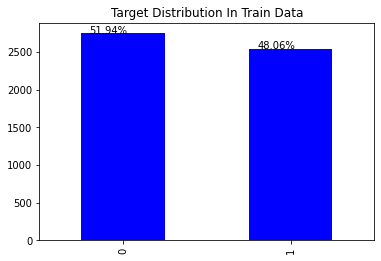

In [ ]:
## see distribution of target variable
ax = tweets['labels'].value_counts().plot.bar(color = 'blue')
size = tweets.shape[0]
for p in ax.patches:
  height, width, x= p.get_height(), p.get_width(), p.get_x()
  percent = height/size * 100
  label = '{:,.2f}%'.format(percent)
  ax.annotate(label, (x + width*0.1, height))

plt.title('Target Distribution In Train Data')
plt.show()


In [ ]:
## see sample tweets
for i in range(20):
  print(tweets['text'][i] + ' _' + str(tweets['labels'][i]))

The bitcoin halving is cancelled due to _1
MercyOfAllah In good times wrapped in its granular detail I challenge myself to find meaning and model the humility t _0
266 Days No Digital India No Murder of e learning No 2g online business No Restore in J amp k _1
India is likely to run out of the remaining RNA kits which are essential for testing in one week What is the gov _1
In these tough times the best way to grow is to learn or in my case teach to help people learn to connect Sports and Anal _0
FIFA has proposed allowing teams to make up to five substitutions per match to help players cope with the return to action _0
Lovers of sports especially do you know why sometimes the time changes All this is done in the name of Daylight Saving Time DST which is the practice of setting the clocks forward one hour from standard time during the summer months and back again in the fall _0
ig he kinda cute sometimes smh _0
Frontline health workers are critical in the fight against infectious disea

**More about Data**

Tweets have been classified as covid-19-related (1) or not covid-19-related (0). All tweets have had the following keywords removed:

* corona
* coronavirus
* covid
* covid19
* covid-19
* sarscov2
* 19

The tweets have also had usernames and web addresses removed to ensure anonymity. The goal is use NLP technique.

More canbe found at [zindi](https://zindi.africa/competitions/zindiweekendz-learning-covid-19-tweet-classification-challenge/data)

## Data preparation and Modelling

### Create a train and validation set

In [ ]:
from sklearn.model_selection import train_test_split
train, validation = train_test_split(tweets, test_size=0.2)

In [ ]:
# create a hugging face dataset from the dataframes above
from datasets import Dataset

In [ ]:
train = Dataset.from_pandas(train, split=['train'])
validation = Dataset.from_pandas(validation, split = 'validation')

In [ ]:
#import autotonizer for tokenizing texts
from transformers import AutoTokenizer

In [ ]:
train.set_format(type = 'pandas')
df = train[:]

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


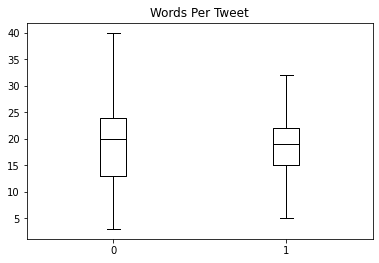

In [ ]:
## check the words per split
df["Words Per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet", by='labels', grid=False,
showfliers=False, color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

We can see that most sententences contain between 13 to 22 with just few outliers

In [ ]:
# reset format
train.reset_format()

In [ ]:
# use ditilbert model
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [ ]:
# function tokenize a batch of text data
def tokenize(batch):
  return tokenizer(batch['text'], padding = True, truncation= True)

In [ ]:
# see sample token outputs
print(tokenize(train[:3]))

{'input_ids': [[101, 1017, 1021, 23689, 2001, 2445, 2000, 17338, 20192, 24658, 4707, 2000, 2470, 2129, 2000, 4652, 3280, 11022, 2015, 2066, 1996, 2027, 15484, 1996, 5029, 2000, 2536, 13625, 3053, 1017, 1018, 1997, 1037, 2454, 2001, 4844, 2011, 8398, 1999, 2322, 8398, 3013, 4804, 2000, 4411, 2008, 2020, 2551, 2000, 3690, 16467, 9252, 18191, 102], [101, 2023, 2028, 2003, 2036, 12168, 2594, 5443, 4887, 3401, 3449, 2239, 14163, 6711, 1998, 1996, 5368, 1997, 1037, 2312, 2206, 9932, 16110, 12528, 27263, 10474, 4012, 1020, 2213, 22022, 4213, 2692, 2615, 4160, 2094, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 4223, 2003, 3585, 2005, 17967, 2004, 5843, 7698, 13416, 4153, 5005, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [ ]:
# encode the texts in train and validation set to tokens
train_encoded = train.map(tokenize, batched= True, batch_size = None)
valid_encoded = validation.map(tokenize, batched= True, batch_size = None)

print(train_encoded.column_names)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

['ID', 'text', 'labels', '__index_level_0__', 'input_ids', 'attention_mask']


### Using Transformer as feature extractor

One of advantages of transformer over traditional RNNS is ability of transfering knowlegde learned from one task to another task. 
 Here we will use distilbert to extract features for learning tweets classification. This will be the best approach for such task owing to the fact that our train data contains very few example and fine-tuning the transformer might not help much.

In [ ]:
from transformers import AutoModel
import torch
import torch.nn.functional as F

In [ ]:

model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

In [ ]:
# function to extract hidden states at the begining of words from a batch tokenized texts
def extract_hidden_states(batch):
  inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
  ## extract last hidden state
  with torch.no_grad():
    last_hidden_state = model(**inputs).last_hidden_state
  # Return vector for [CLS] token
  return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [ ]:
## convert the data to torch tensors since the model expects torch inputs
train_encoded.set_format("torch",columns=["input_ids", "attention_mask", 'labels'])
valid_encoded.set_format("torch",columns=["input_ids", "attention_mask", 'labels'])

## extract hidden states from train and validation set
train_hidden = train_encoded.map(extract_hidden_states, batched=True)
valid_hidden = valid_encoded.map(extract_hidden_states, batched=True)

  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [ ]:
# extract features and labels for training 
import numpy as np
X_train = np.array(train_hidden['hidden_state'])
X_valid = np.array(valid_hidden['hidden_state'])
y_train = np.array(train_hidden['labels'])
y_valid = np.array(valid_hidden['labels'])
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((4229, 768), (1058, 768), (4229,), (1058,))

Our features has 768 dimensions, lets try map this 768 features set to a 2-dimensional space and visualize the hidden state results from the transformer using umap

In [ ]:
# create a visualization to ensure we get a good presentation of emotions
from umap.umap_ import UMAP
from sklearn.preprocessing import MinMaxScaler ## umap works better with scaled data

In [ ]:
X_scaled = MinMaxScaler().fit_transform(X_train)
mapper = UMAP(n_components = 2, metric = 'cosine').fit(X_scaled)
# create dataframe of 2-d emd
df_emd = pd.DataFrame(mapper.embedding_, columns = ['X', 'Y'])
df_emd['label'] = y_train
df_emd.head()

,X,Y,label
0,8.849734,5.025486,1
1,10.352353,1.934311,0
2,8.127581,3.157930,1
3,9.722955,5.999780,1
4,6.096019,2.649142,0


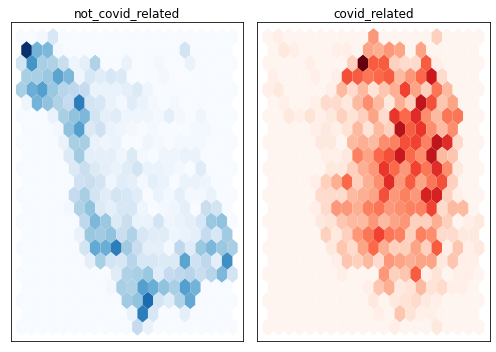

In [ ]:
## lets plot density of each category separately
fig, axes = plt.subplots(1, 2, figsize=(7,5))
axes = axes.flatten()
cmaps = [ "Blues", "Reds"]
labels = [ 'not_covid_related','covid_related']
for i, (label, cmap) in enumerate(zip(labels, cmaps)):
  df_emb_sub = df_emd.query(f"label == {i}")
  axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
  gridsize=20, linewidths=(0,))
  axes[i].set_title(label)
  axes[i].set_xticks([]), axes[i].set_yticks([])
plt.tight_layout()
plt.show()

Looking at the density plots above, there is a clear distinction between covid related tweets and non-covid related tweets. Covid related tweets are more concentrated at the centre. This shows how distilbert models does perfectly well in extracting useful features from tweets, which canbe easily model with a logistics regression model

In [ ]:
from sklearn.linear_model import LogisticRegression
# We increase `max_iter` to guarantee convergence
lr_clf = LogisticRegression(max_iter=3000, random_state = 42)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.888468809073724

In [ ]:
## check model performance against a dummy model
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.5122873345935728

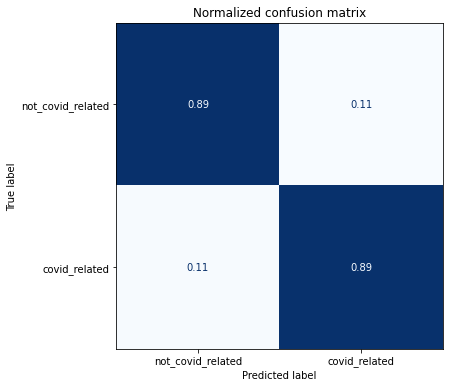

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
def plot_confusion_matrix(y_preds, y_true, labels):
  cm = confusion_matrix(y_true, y_preds, normalize="true")
  fig, ax = plt.subplots(figsize=(6, 6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
  plt.title("Normalized confusion matrix")
  plt.show()

y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

Yeah! how model is doing great when compared a dummy classifier. Alot has been learned owing to the fact that key corona related words were removed

### Making prediction on test set

In [ ]:
## preprocess the test dataframe
test_X = Dataset.from_pandas(test, split=['test'])
test_encoded = test_X.map(tokenize, batched= True, batch_size = None)
test_encoded.set_format("torch",columns=["input_ids", "attention_mask"])
test_hidden = test_encoded.map(extract_hidden_states, batched=True)
test_X = np.array(test_hidden['hidden_state'])
test_X.shape

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

(1962, 768)

In [ ]:
#fit the lr_clf on the whole train set
X = np.append(X_train,X_valid, axis = 0) 
y = np.append(y_train,y_valid, axis = 0) 
lr_clf.fit(X, y)
X.shape, y.shape

((5287, 768), (5287,))

In [ ]:
## making predictions
preds = lr_clf.predict_proba(test_X)
y_test = lr_clf.predict(test_X)

In [ ]:
sub_df = pd.DataFrame({'ID': test.ID, 'target':preds[:,1]})
sub_df.to_csv('submission_4', index = False)

## show the test set along with predictions
test_df = sub_df
test_df['text'] = test['text']
test_df['target'] = y_test
test_df['label_name'] = test_df['target'].map(lambda x : 'covid-19-related' if x == 1 else 'not covid-19-related')
test_df.head()

,ID,target,text,label_name
0,test_2,1,Why is explained in the video take a look,covid-19-related
1,test_3,0,Ed Davey fasting for Ramadan No contest,not covid-19-related
2,test_4,0,Is Doja Cat good or do you just miss Nicki Minaj,not covid-19-related
3,test_8,1,How Boris Johnson s cheery wounded in action p...,covid-19-related
4,test_9,0,Man it s terrible Not even a reason to get on ...,not covid-19-related


In [ ]:
for i in range(10):
  print(test_df['text'][i] + ' _' + test_df['label_name'][i])

Why is  explained in the video take a look _covid-19-related
Ed Davey fasting for Ramadan No contest _not covid-19-related
Is Doja Cat good or do you just miss Nicki Minaj _not covid-19-related
How Boris Johnson s cheery wounded in action persona may save him yet again Let s hope not Johnso _covid-19-related
Man it s terrible Not even a reason to get on here until sports start back _not covid-19-related
The month starts with mercy and blessings going with forgiveness and ends at freedom from hellfire is the only one Ramadan _not covid-19-related
Everyone must do their part Breakfast and Sweet Tea Family comes first No snooze button Work now travel later Have fun while _not covid-19-related
Friends come together to get free food across US from farms to those in need ABC News via _covid-19-related
There are two confirmed cases at MSP1 some fear Amazon is hiding others The elimination of unlimited unpaid time _covid-19-related
Let s protect our mother Nature _not covid-19-related


Performance on test set is quite great

### See model performance on finetuned distilbert

In [ ]:
from transformers import AutoModelForSequenceClassification

In [ ]:
num_labels = 2
model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels = num_labels).to(device))

In [ ]:
# create metric for evaluating model
from sklearn.metrics import accuracy_score, log_loss, f1_score

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average="weighted")
  acc = accuracy_score(labels, preds)
  return {"accuracy": acc, "f1": f1}

In [ ]:
# uncomment to login to hub and push model also set push to hub parameter to true
# from huggingface_hub import notebook_login
# notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


In [ ]:
from transformers import Trainer, TrainingArguments

In [ ]:
# define train parameters
batch_size = 64
logging_steps = len(train_encoded) // batch_size
model_name = f"{model_ckpt}-finetuned-zindi_tweets"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=5,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  log_level="error")

In [ ]:
#train model
trainer = Trainer(model = model,args=training_args,compute_metrics=compute_metrics,train_dataset=train_encoded, 
                  eval_dataset = valid_encoded, tokenizer = tokenizer)

trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.301400,0.255879,0.901701,0.901714
2,0.192300,0.243315,0.903592,0.903596
3,0.121700,0.254041,0.912098,0.912086
4,0.101200,0.259308,0.907372,0.907382
5,0.073300,0.266242,0.911153,0.911166


TrainOutput(global_step=335, training_loss=0.1564193541434274, metrics={'train_runtime': 162.1648, 'train_samples_per_second': 130.392, 'train_steps_per_second': 2.066, 'total_flos': 437659866340800.0, 'train_loss': 0.1564193541434274, 'epoch': 5.0})

In [ ]:
# trainer.push_to_hub(commit_message="Training completed!")

Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 3.34k/255M [00:00<?, ?B/s]

Upload file runs/Jun29_15-24-13_a3fa9a161f95/events.out.tfevents.1656516267.a3fa9a161f95.74.10:  42%|####2    …

To https://huggingface.co/okite97/distilbert-base-uncased-finetuned-zindi_tweets
   1a68447..f83fd9a  main -> main

To https://huggingface.co/okite97/distilbert-base-uncased-finetuned-zindi_tweets
   f83fd9a..2c5b724  main -> main



'https://huggingface.co/okite97/distilbert-base-uncased-finetuned-zindi_tweets/commit/f83fd9a7faa6a92d66aefd0d3a03b93aee6ca06e'

In [ ]:
## use pipeline to make predictions on new texts
from transformers import pipeline
model_id = "okite97/distilbert-base-uncased-finetuned-zindi_tweets"
classifier = pipeline("text-classification", model=model_id)

Downloading:   0%|          | 0.00/615 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/255M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/360 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/695k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [ ]:
f_preds = classifier(list(test['text'].values), return_all_scores=True)

/usr/local/lib/python3.7/dist-packages/transformers/pipelines/text_classification.py:90: UserWarning: `return_all_scores` is now deprecated, use `top_k=1` if you want similar functionnality
  "`return_all_scores` is now deprecated, use `top_k=1` if you want similar functionnality", UserWarning


In [ ]:
y = []
for i in range(len(f_preds)):
  y.append(preds[i][1]['score'])

In [ ]:
preds[0][0]['score']

0.0276089645922184

In [ ]:
sub_df = pd.DataFrame({'ID': test.ID, 'target':y})
sub_df.to_csv('submission_5', index = False)

There was just slight improvement with finetuning, its not surprising as fine tuninng transfomers shines where there is lots of data.
